In [158]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [159]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#locating the dataset, getting rid of any NA values, and printing the first 10 rows
dataset = pd.read_csv('/content/drive/My Drive/housing.csv')
dataset = dataset.dropna()
print("Here are the first ten rows of the dataset:")
dataset.head(10)


Here are the first ten rows of the dataset:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a40427550>,
      dtype=object)

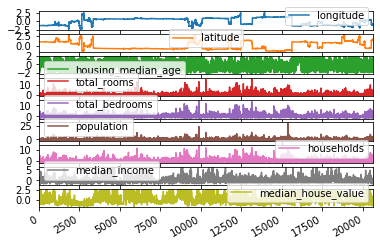

In [0]:
#Plotting the dataset
dataset.plot(subplots=True)

In [160]:
#getting the X and Y values
X = dataset.loc[:, 'longitude':'median_income']
Y = dataset['median_house_value']

#splitting the data 70:30 for training and testing respectively
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2003)
print("There are " + str(x_train.size) + " training entries and "+
      str(x_test.size) + " testing entries!")

#converting the testing and training sets to numpy arrays
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()

x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

There are 114424 training entries and 49040 testing entries!


In [0]:
import torch
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset

In [0]:
class CnnRegressor(torch.nn.Module):
  def __init__(self, batch_size, inputs, outputs):
    
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs

    self.input_layer = Conv1d(inputs, batch_size, 1)

    self.max_pooling_layer = MaxPool1d(1)

    self.conv_layer = Conv1d(batch_size, 64, 1)

    self.flatten_layer = Flatten()

    self.linear_layer = Linear(64, batch_size)

    self.output_layer = Linear(batch_size, outputs)

  def feed(self, input):
    
    input = input.reshape((self.batch_size, self.inputs, 1))

    output = relu(self.input_layer(input))

    output = self.max_pooling_layer(output)

    output = relu(self.conv_layer(output))

    output = self.flatten_layer(output)

    output = self.linear_layer(output)

    output = self.output_layer(output)

    return output

In [163]:
from torch.optim import SGD
from torch.nn import L1Loss
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score
from sklearn.metrics import mean_squared_error
import time

In [164]:
batch_size = 32
model = CnnRegressor(batch_size, X.shape[1], 1)

model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 32, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=64, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [0]:
def model_loss(model, dataset, train = False, optimizer = None):

  performance = L1Loss()
  score_metric = R2Score()

  avg_loss = 0
  avg_score = 0
  avg_mse = 0
  count = 0

  for input, output in iter(dataset):
    predictions = model.feed(input)

    loss = performance(predictions, output)

    score_metric.update([predictions, output])
    score = score_metric.compute()

    mse = mean_squared_error(output.cpu(), predictions.cpu().detach().numpy())

    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    avg_loss += loss.item()
    avg_score += score
    count += 1
    avg_mse+=mse

  return avg_loss / count, avg_score / count, avg_mse / count

In [168]:
epochs = 50

optimizer = SGD(model.parameters(), lr=1e-5)

inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()

tensor = TensorDataset(inputs, outputs)

loader = DataLoader(tensor, batch_size, shuffle = True, drop_last = True)

tic = time.perf_counter() #starts a timer for the training time

for epoch in range(epochs):
  avg_loss, avg_r2_score, avg_mse = model_loss(model, loader, train=True, optimizer=optimizer)
  print("Epoch "+ str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score) + ":\n\tMSE = " + str(avg_mse))

toc = time.perf_counter() #ends the timer

print(f"Model was trained in {toc - tic:0.4f} seconds")
  

inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()

avg_loss, avg_r2_score, avg_mse = model_loss(model, loader)

print("The model's L1 loss is:"+str(avg_loss))
print("The model's R^2 score is:"+str(avg_r2_score))
print("The model's MSE is:"+str(avg_mse))

Epoch 1:
	Loss = 76195.448789588
	R^2 Score = 0.23623614267685306:
	MSE = 10027538287.35426
Epoch 2:
	Loss = 76023.5902816704
	R^2 Score = 0.2663751297757471:
	MSE = 9977501921.004484
Epoch 3:
	Loss = 76585.89354154989
	R^2 Score = 0.22498945419945512:
	MSE = 10185520741.02242
Epoch 4:
	Loss = 76695.42543967208
	R^2 Score = 0.23711545147405058:
	MSE = 10333990635.910315
Epoch 5:
	Loss = 75988.10245585762
	R^2 Score = 0.22912846060363753:
	MSE = 10030444329.901346
Epoch 6:
	Loss = 75363.86384178812
	R^2 Score = 0.2224600280586279:
	MSE = 9931890456.681614
Epoch 7:
	Loss = 75775.86453370235
	R^2 Score = 0.22913620935280996:
	MSE = 10049434486.816143
Epoch 8:
	Loss = 76339.96275049046
	R^2 Score = 0.21918251072407496:
	MSE = 10139209376.143497
Epoch 9:
	Loss = 75678.69307034754
	R^2 Score = 0.23380247941221746:
	MSE = 9974687502.923767
Epoch 10:
	Loss = 75192.61130184977
	R^2 Score = 0.27231555923044903:
	MSE = 9807339019.47982
Epoch 11:
	Loss = 75814.20957994675
	R^2 Score = 0.2456565264

In [171]:
#saves the trained model to the disk
torch.save(model, "0655603_1dconv reg.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CnnRegressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
